In this example we show how someone can simulate the signal and the ODF of **a single voxel** using a MultiTensor.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.data import get_sphere
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.viz import window, actor

In [4]:
#For the simulation we will need a GradientTable with the b-values and b-vectors. To create one, we can first create some random points on a HemiSphere using spherical polar coordinates.
n_pts = 64
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta = theta, phi = phi)

In [5]:
#Next, we call disperse_charges which will iteratively move the points so that the electrostatic potential energy is minimized.
hsph_updated, potential = disperse_charges(hsph_initial, 5000)

In [6]:
#We will use 2-shell (multishell) technique. That means there will be 2 different non-zero b values that will be applied for each direction. First one is 1000, the second one is 2500.

vertices = hsph_updated.vertices
values = np.ones(vertices.shape[0])

bvecs = np.vstack((vertices, vertices))
bvals = np.hstack((1000 * values, 2500 * values))

In [7]:
#Vertices: These are directions in 3D space corresponding to different diffusion gradient directions.
print(vertices.shape)

#values: These represent the strength of the diffusion weighting applied in each direction (vertex).
print(values.shape)

#Two shell representation:
print(bvecs.shape)
print(bvals.shape)

(64, 3)
(64,)
(128, 3)
(128,)


In [8]:
#We can also add some b0s. Let’s add one at the beginning and one at the end. The b=0 images represent the signal acquired without diffusion weighting (i.e., when the diffusion gradients are turned off). These images serve as a reference point for the baseline signal intensity in the absence of diffusion effects.

#Note that: S(b) = S0 * e^(-b * ADC).   Higher b --> higher diffusion.
bvecs = np.insert(bvecs, (0, bvecs.shape[0]), np.array([0, 0, 0]), axis = 0)
bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

In [9]:
#Let’s now create the GradientTable. Bvals and bvecs are used only here.
gtab = gradient_table(bvals, bvecs)

In [10]:
#In mevals we save the eigenvalues of each tensor. We will have one crossing, therefore there will be two tensors in this voxel.
mevals = np.array([[0.0015, 0.0003, 0.0003],
                   [0.0015, 0.0003, 0.0003]])

In [11]:
#In angles we save in polar coordinates (theta, phi), principal axis for each tensor.
angles = [(0, 0), (60, 0)]

In [12]:
#In fractions we save the percentage of the contribution of each tensor
fractions = [50, 50]

In [13]:
#The function multi_tensor will return the simulated signal and an array with the principal axes of the tensors in cartesian coordinates.
signal, sticks = multi_tensor(gtab, mevals, S0 = 100, angles = angles,
                              fractions = fractions, snr = None)

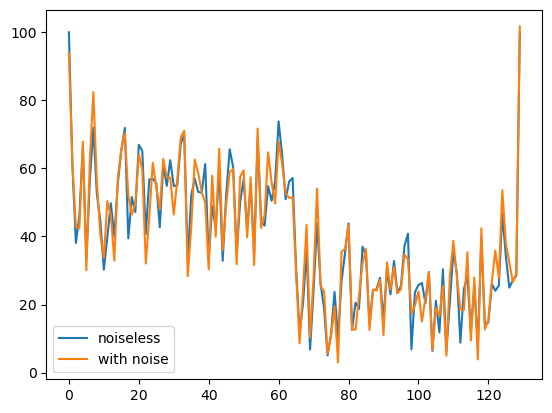

In [14]:
#We can also add Rician noise with a specific SNR.
signal_noisy, sticks = multi_tensor(gtab, mevals, S0 = 100, angles = angles,
                                    fractions=fractions, snr = 20)

plt.plot(signal, label = 'noiseless')

plt.plot(signal_noisy, label = 'with noise')
plt.legend()
plt.show()

In [15]:
print(signal_noisy.shape)
signal
#This is the resulting multitensor. As can be seen, first half is higher (low diffusion), and second half is lower (high diffusion). Note that we have low diffusion at the first angle (0) because there is a fiber in that direction?

(130,)


array([100.        ,  60.91596479,  38.08775424,  46.04092175,
        66.49697562,  33.48728315,  56.64329843,  71.95581911,
        52.4579357 ,  44.58546099,  30.24025627,  39.76279141,
        49.78677678,  39.95902814,  55.70342833,  65.29612438,
        71.90198905,  39.43747552,  51.59132178,  47.20785341,
        66.96707969,  65.14178403,  40.6778785 ,  56.74852428,
        56.94092331,  55.68070855,  42.71219735,  61.12233653,
        54.88905591,  62.41134534,  54.82894976,  55.04193152,
        67.32528359,  69.88231728,  32.67198316,  52.04692058,
        57.04074019,  53.0880931 ,  52.87885206,  61.286536  ,
        33.20903024,  48.93955727,  42.54176188,  59.66411998,
        32.84402479,  52.3000433 ,  65.61997435,  60.32877209,
        34.92369491,  50.21552837,  56.76532235,  41.96706097,
        55.17861572,  35.1253227 ,  68.7336801 ,  44.30996684,
        43.1973325 ,  54.76405124,  50.49021102,  56.26575377,
        73.82266402,  64.084936  ,  50.94139649,  56.09

In [16]:
indices = np.argpartition(signal[70:90], -5)[-5:]
    
# Sort the indices based on the corresponding values
indices_sorted = indices[np.argsort(signal[indices])][::-1]
    
# Get the two maximum values and their corresponding indices
max_values = signal[indices_sorted]
max_indices = indices_sorted
print(max_values)
print(max_indices)
print(np.degrees(np.arccos(bvecs[max_indices]))-90)

[65.29612438 60.91596479 55.70342833 44.58546099 30.24025627]
[15  1 14  9 10]
[[  5.59774893  62.70596105 -26.61943071]
 [ 30.47231583 -39.87982973 -35.16604943]
 [ 67.85222659  20.17440933  -8.75827456]
 [-71.61026912   0.35251237 -18.38610827]
 [-33.36464792   0.5440764  -56.62972846]]


In [17]:
#For the ODF simulation we will need a sphere. Because we are interested in a simulation of only a single voxel, we can use a sphere with very high resolution. We generate that by subdividing the triangles of one of DIPY_’s cached spheres, which we can read in the following way.

sphere = get_sphere('repulsion724')
sphere = sphere.subdivide(2)

#Creating the orientation distribution function:
odf = multi_tensor_odf(sphere.vertices, mevals, angles, fractions)

# Enables/disables interactive visualization
interactive = False

scene = window.Scene()

odf_actor = actor.odf_slicer(odf[None, None, None, :], sphere=sphere,
                             colormap='plasma')
odf_actor.RotateX(90)

scene.add(odf_actor)

print('Saving illustration as multi_tensor_simulation')
window.record(scene, out_path='multi_tensor_simulation.png', size=(300, 300))
if interactive:
    window.show(scene)

Saving illustration as multi_tensor_simulation
